In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

resultsPath = Path("../results/MPI_2.csv")


In [2]:
dataFrame = pd.read_csv(resultsPath)
dataFrame["problemSize"] = dataFrame["problemSize"].astype(int)
dataFrame["numProcesses"] = dataFrame["numProcesses"].astype(int)
dataFrame["timeSeconds"] = dataFrame["timeSeconds"].astype(float)
dataFrame["runIndex"] = dataFrame["runIndex"].astype(int)

print("Loaded rows:", len(dataFrame))
print("Problem sizes:", sorted(dataFrame["problemSize"].unique()))
print("Process counts:", sorted(dataFrame["numProcesses"].unique()))
dataFrame.head(8)


Loaded rows: 105
Problem sizes: [1000000, 5000000, 10000000]
Process counts: [1, 2, 4, 6, 8, 16, 32]


,testType,problemSize,numProcesses,timeSeconds,dotProduct,runIndex,mpiEnv
0,MPI_2,1000000,1,0.001471,249789.637746,1,PROCS=1
1,MPI_2,1000000,1,0.001392,249946.800646,2,PROCS=1
2,MPI_2,1000000,1,0.001245,249586.768027,3,PROCS=1
3,MPI_2,1000000,1,0.001377,249718.944592,4,PROCS=1
4,MPI_2,1000000,1,0.001260,250117.744514,5,PROCS=1
5,MPI_2,1000000,2,0.001208,249818.813875,1,PROCS=2
6,MPI_2,1000000,2,0.001172,250207.726725,2,PROCS=2
7,MPI_2,1000000,2,0.001473,250024.769675,3,PROCS=2


In [3]:
groupedFrame = dataFrame.groupby(["problemSize","numProcesses"], as_index=False).agg(
    median=("timeSeconds","median"),
    mean=("timeSeconds","mean"),
    std=("timeSeconds","std"),
    count=("timeSeconds","count")
)
groupedFrame["std"] = groupedFrame["std"].fillna(0.0)
groupedFrame = groupedFrame.sort_values(["problemSize","numProcesses"]).reset_index(drop=True)
groupedFrame.head(12)


,problemSize,numProcesses,median,mean,std,count
0,1000000,1,0.001377,0.001349,0.000095,5
1,1000000,2,0.001422,0.001340,0.000139,5
2,1000000,4,0.001541,0.001516,0.000084,5
3,1000000,6,0.001784,0.001791,0.000031,5
4,1000000,8,0.002325,0.002270,0.000099,5
5,1000000,16,0.003877,0.003895,0.000123,5
6,1000000,32,0.007164,0.007167,0.000056,5
7,5000000,1,0.006102,0.006177,0.000157,5
8,5000000,2,0.006244,0.006210,0.000186,5
9,5000000,4,0.007091,0.007033,0.000183,5


In [5]:
def computeSpeedupEfficiency(groupedDf):
    frames = []
    for problemSizeVal, subFrame in groupedDf.groupby("problemSize"):
        baseRows = subFrame[subFrame["numProcesses"] == 1]
        if baseRows.empty:
            continue
        baseTime = float(baseRows["median"].values[0])
        subFrame = subFrame.copy()
        subFrame["speedup"] = baseTime / subFrame["median"]
        subFrame["efficiency"] = subFrame["speedup"] / subFrame["numProcesses"]
        frames.append(subFrame)
    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, ignore_index=True)

perfFrame = computeSpeedupEfficiency(groupedFrame)
perfFrame.head(12)


,problemSize,numProcesses,median,mean,std,count,speedup,efficiency
0,1000000,1,0.001377,0.001349,0.000095,5,1.000000,1.000000
1,1000000,2,0.001422,0.001340,0.000139,5,0.968354,0.484177
2,1000000,4,0.001541,0.001516,0.000084,5,0.893576,0.223394
3,1000000,6,0.001784,0.001791,0.000031,5,0.771861,0.128643
4,1000000,8,0.002325,0.002270,0.000099,5,0.592258,0.074032
5,1000000,16,0.003877,0.003895,0.000123,5,0.355172,0.022198
6,1000000,32,0.007164,0.007167,0.000056,5,0.192211,0.006007
7,5000000,1,0.006102,0.006177,0.000157,5,1.000000,1.000000
8,5000000,2,0.006244,0.006210,0.000186,5,0.977258,0.488629
9,5000000,4,0.007091,0.007033,0.000183,5,0.860527,0.215132


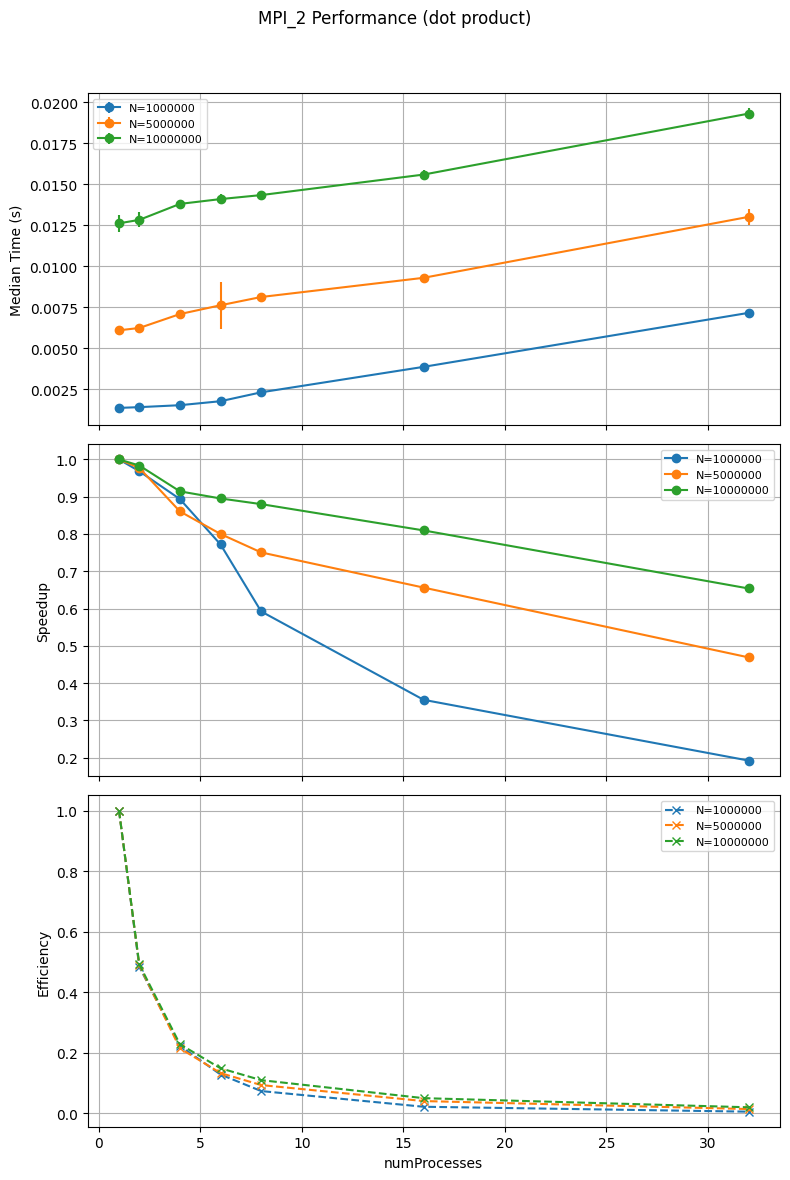

In [6]:
metrics = ["median", "speedup", "efficiency"]
metricLabels = {"median":"Median Time (s)", "speedup":"Speedup", "efficiency":"Efficiency"}

problemSizeList = sorted(perfFrame["problemSize"].unique())
processList = sorted(perfFrame["numProcesses"].unique())

fig, axes = plt.subplots(len(metrics), 1, figsize=(8, 12), sharex=True)
if len(metrics) == 1:
    axes = [axes]

for rowIdx, metric in enumerate(metrics):
    ax = axes[rowIdx]
    for problemSizeVal in problemSizeList:
        subFrame = perfFrame[perfFrame["problemSize"] == problemSizeVal].sort_values("numProcesses")
        if subFrame.empty:
            continue
        x = subFrame["numProcesses"].values
        y = subFrame[metric].values
        if metric == "median":
            yerr = subFrame["std"].values
            ax.errorbar(x, y, yerr=yerr, marker='o', linestyle='-', label=f"N={problemSizeVal}")
        else:
            linestyle = '-' if metric == 'speedup' else '--'
            markerStyle = 'o' if metric == 'speedup' else 'x'
            ax.plot(x, y, marker=markerStyle, linestyle=linestyle, label=f"N={problemSizeVal}")
    ax.set_ylabel(metricLabels[metric])
    ax.grid(True)
    ax.legend(fontsize=8)

axes[-1].set_xlabel('numProcesses')
plt.suptitle('MPI_2 Performance (dot product)')
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


In [8]:
display(perfFrame.pivot_table(index="numProcesses", columns="problemSize", values="median"))
summaryRows = []
for problemSizeVal, sub in perfFrame.groupby("problemSize"):
    maxSpeedup = sub["speedup"].max()
    argMax = sub.loc[sub["speedup"].idxmax()]
    bestProcs = int(argMax["numProcesses"])
    effAtBest = float(argMax["efficiency"])
    medianAtOne = sub.loc[sub["numProcesses"]==1, "median"]
    medianAtOne = float(medianAtOne.values[0]) if not medianAtOne.empty else np.nan
    summaryRows.append({
        "problemSize": problemSizeVal,
        "bestNumProcesses": bestProcs,
        "maxSpeedup": maxSpeedup,
        "efficiencyAtBest": effAtBest,
        "medianTime1Process": medianAtOne
    })

summaryFrame = pd.DataFrame(summaryRows).sort_values("problemSize")
display(summaryFrame)


problemSize,1000000,5000000,10000000
numProcesses,,,
1,0.001377,0.006102,0.012618
2,0.001422,0.006244,0.012828
4,0.001541,0.007091,0.013800
6,0.001784,0.007628,0.014094
8,0.002325,0.008130,0.014337
16,0.003877,0.009299,0.015586
32,0.007164,0.013010,0.019298


,problemSize,bestNumProcesses,maxSpeedup,efficiencyAtBest,medianTime1Process
0,1000000,1,1.0,1.0,0.001377
1,5000000,1,1.0,1.0,0.006102
2,10000000,1,1.0,1.0,0.012618
